# Tutorial goal

This tutorial aims to show how to **configure** a **test environment** using
the **TestEnv module** provided by LISA.

# Configure logging

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-09-07 07:00:27,441 INFO    : root         : Using LISA logging configuration:
2017-09-07 07:00:27,442 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
# Execute this cell to enabled devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [3]:
# Other python modules required by this notebook
import json
import time
import os

# Test environment setup

## Do you have custom scripts to deploy and use on target?

In [4]:
# Custom scrips must be deployed under $LISA_HOME/tools
!tree ../../tools

../../tools
|-- LICENSE.perf
|-- LICENSE.rt-app
|-- LICENSE.sysbench
|-- LICENSE.taskset
|-- LICENSE.trace-cmd
|-- arm64
|   |-- README.rt-app
|   |-- README.taskset
|   |-- README.trace-cmd
|   |-- perf
|   |-- rt-app
|   |-- sysbench
|   |-- taskset
|   `-- trace-cmd
|-- armeabi
|   |-- README.rt-app
|   |-- perf
|   |-- rt-app
|   |-- sysbench
|   |-- taskset
|   `-- trace-cmd
|-- catapult
|   |-- AUTHORS
|   |-- CONTRIBUTING.md
|   |-- LICENSE
|   |-- OWNERS
|   |-- PRESUBMIT.py
|   |-- README.md
|   |-- WATCHLISTS
|   |-- bin
|   |   |-- run_dev_server
|   |   `-- run_tests
|   |-- catapult_base
|   |   `-- catapult_base
|   |       `-- update_reference_build
|   |-- catapult_build
|   |   |-- PRESUBMIT.py
|   |   |-- __init__.py
|   |   |-- appengine_deploy.py
|   |   |-- appengine_dev_server.py
|   |   |-- bin
|   |   |   `-- run_py_tests
|   |   |-- bin_checks.py
|   |   |-- build_steps.py
|   |   |-- build_steps_unittest.py
|   |   |-- dev_server.py
|   |   |-- dev_server_unit

|   |   |   |-- base_config.pyc
|   |   |   |-- base_config_unittest.py
|   |   |   |-- cloud_storage_info.py
|   |   |   |-- cloud_storage_info.pyc
|   |   |   |-- cloud_storage_info_unittest.py
|   |   |   |-- dependency_info.py
|   |   |   |-- dependency_info.pyc
|   |   |   |-- dependency_info_unittest.py
|   |   |   |-- dependency_manager_unittest.py
|   |   |   |-- dependency_manager_util.py
|   |   |   |-- dependency_manager_util.pyc
|   |   |   |-- dependency_manager_util_unittest.py
|   |   |   |-- exceptions.py
|   |   |   |-- exceptions.pyc
|   |   |   |-- local_path_info.py
|   |   |   |-- local_path_info.pyc
|   |   |   |-- manager.py
|   |   |   |-- manager.pyc
|   |   |   |-- uploader.py
|   |   |   |-- uploader.pyc
|   |   |   `-- uploader_unittest.py
|   |   `-- pylintrc
|   |-- devil
|   |   |-- OWNERS
|   |   |-- PRESUBMIT.py
|   |   |-- README.md
|   |   |-- bin
|   |   |   |-- generate_md_docs
|   |   |   |-- run_py_devicetests
|   |   |   `-- run_py_tests
|   |   

|   |   |       |   |   |   |-- spotpricehistory.py
|   |   |       |   |   |   |-- tag.py
|   |   |       |   |   |   |-- volume.py
|   |   |       |   |   |   |-- volumestatus.py
|   |   |       |   |   |   `-- zone.py
|   |   |       |   |   |-- ec2containerservice
|   |   |       |   |   |   |-- __init__.py
|   |   |       |   |   |   |-- exceptions.py
|   |   |       |   |   |   `-- layer1.py
|   |   |       |   |   |-- ecs
|   |   |       |   |   |   |-- __init__.py
|   |   |       |   |   |   `-- item.py
|   |   |       |   |   |-- elasticache
|   |   |       |   |   |   |-- __init__.py
|   |   |       |   |   |   `-- layer1.py
|   |   |       |   |   |-- elastictranscoder
|   |   |       |   |   |   |-- __init__.py
|   |   |       |   |   |   |-- exceptions.py
|   |   |       |   |   |   `-- layer1.py
|   |   |       |   |   |-- emr
|   |   |       |   |   |   |-- __init__.py
|   |   |       |   |   |   |-- bootstrap_action.py
|   |   |       |   |   |   |-- connection.py
|   |

In [5]:
# This is the (not so fancy) script we want to deploy
!cat ../../tools/scripts/cpuidle_sampling.sh

#!/system/bin/sh

# CPU to monitor
CPU=${1:-0}
# Sampling time
SLEEP=${2:-1}
# Samples to collect
COUNT=${3:-3}

# Enter CPU's sysfs
cd /sys/devices/system/cpu

# Initial C-State residencies counter
ISC=$(find cpu0/cpuidle -name "state*" | wc -l)
for I in $(seq 0 $((ISC-1))); do
	LCS[$I]=`cat cpu$CPU/cpuidle/state$I/usage`
done

# Dump header
printf "#%13s " "Time"
for I in $(seq 0 $((ISC-1))); do
  printf "%14s " "idle$I"
done
echo

# Sampling loop
for I in $(seq $COUNT); do

	sleep $SLEEP

	# Dump CPU C-State residencies
	now=$(date +%s)
	printf "%14d " $now
	for I in $(seq 0 $((ISC-1))); do
		U=`cat cpu$CPU/cpuidle/state$I/usage`
		CCS=$(($U - ${LCS[$I]}))
		printf "%14d " $CCS
		LCS[$I]=$U
	done
	echo


done

# vim: ts=2


## Which devlib modules you need for your experiments?

In [6]:
# You can have a look at the devlib supported modules by lising the
devlib_modules_folder = 'libs/devlib/devlib/module/'

logging.info("Devlib provided modules are found under:")
logging.info("   $LISA_HOME/{}".format(devlib_modules_folder))
!cd ../../ ; find {devlib_modules_folder} -name "*.py" | sed 's|libs/devlib/devlib/module/|   |' | grep -v __init__ 

2017-09-07 07:00:35,716 INFO    : root         : Devlib provided modules are found under:
2017-09-07 07:00:35,719 INFO    : root         :    $LISA_HOME/libs/devlib/devlib/module/


   android.py
   biglittle.py
   cgroups.py
   cooling.py
   cpufreq.py
   cpuidle.py
   gem5stats.py
   hotplug.py
   hwmon.py
   thermal.py
   vexpress.py


## Setup you TestEnv confguration

In [7]:
# Setup a target configuration
conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Custom tools to deploy on target, they must be placed under:
    #   $LISA_HOME/tools/(ARCH|scripts)
    "tools" : [ "cpuidle_sampling.sh" ],

    # FTrace configuration
    "ftrace" : {
         "events" : [
             "cpu_idle",
             "sched_switch",
         ],
         "buffsize" : 10240,
    },
    
    # Where results are collected
    "results_dir" : "TestEnvExample",
    
    # Devlib module required (or not required)
    'modules' : [ "cpufreq", "cgroups" ],
    #"exclude_modules" : [ "hwmon" ],
    
    # Local installation path used for kernel/dtb installation on target
    # The specified path MUST be accessible from the board, e.g.
    # - JUNO/TC2: it can be the mount path of the VMESD disk image
    # - Other board: it can be a TFTP server path used by the board bootloader
    "tftp"  : {
        "folder"    : "/var/lib/tftpboot",
        "kernel"    : "kern.bin",
        "dtb"       : "dtb.bin",
    },

}

In [8]:
from env import TestEnv

# Initialize a test environment using the provided configuration
te = TestEnv(conf)

2017-09-07 07:00:40,367 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-07 07:00:40,369 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-07 07:00:40,370 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-09-07 07:00:40,372 WARNING : TestEnv      :    /home/lisa/lisa-github/results/TestEnvExample
2017-09-07 07:00:40,374 INFO    : TestEnv      : External tools using:
2017-09-07 07:00:40,375 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-07 07:00:40,377 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-07 07:00:40,378 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
2017-09-07 07:00:40,379 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-07 07:00:40,381 INFO    : TestEnv      : Connection settings:
2017-09-07 07:00:40,382 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}

## Attributes

The initialization of the test environment pre-initialize some useful<br>
environment variables which are available to write test cases.

These are some of the information available via the TestEnv object.

In [9]:
# The complete configuration of the target we have configured
print json.dumps(te.conf, indent=4)

{
    "ftrace": {
        "buffsize": 10240, 
        "events": [
            "cpu_idle", 
            "sched_switch"
        ]
    }, 
    "rtapp-calib": {
        "1": 302, 
        "0": 302, 
        "3": 304, 
        "2": 304, 
        "5": 137, 
        "4": 136, 
        "7": 136, 
        "6": 136
    }, 
    "device": "0123456789ABCDEF", 
    "ANDROID_HOME": "/home/lisa/android-sdk", 
    "tools": [
        "cpuidle_sampling.sh"
    ], 
    "emeter": {
        "instrument": "acme", 
        "channel_map": {
            "Device1": 1, 
            "Device0": 0
        }, 
        "conf": {
            "iio-capture": "/usr/bin/iio-capture", 
            "ip_address": "10.169.36.36"
        }
    }, 
    "modules": [
        "cpufreq", 
        "cgroups"
    ], 
    "results_dir": "TestEnvExample", 
    "platform": "android", 
    "board": "hikey960", 
    "__features__": [], 
    "tftp": {
        "kernel": "kern.bin", 
        "folder": "/var/lib/tftpboot", 
        "dtb": "dtb.

In [10]:
# Last configured kernel and DTB image
print te.kernel
print te.dtb

None
None


In [11]:
# The IP and MAC address of the target
print te.ip
print te.mac

None
None


In [12]:
# A full platform descriptor
print json.dumps(te.platform, indent=4)

{
    "kernel": {
        "version_number": 4, 
        "sha1": "4a80fc6", 
        "major": 4, 
        "parts": [
            4, 
            4, 
            79
        ], 
        "version": "15 SMP PREEMPT Mon Sep 4 13:33:06 CST 2017", 
        "rc": null, 
        "release": "4.4.79-g4a80fc6", 
        "minor": 79
    }, 
    "abi": "arm64", 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 413
            }, 
            "cpu": {
                "cap_max": 1023, 
                "nrg_max": 1214
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 84
            }, 
            "cpu": {
                "cap_m

In [13]:
# A pre-created folder to host the tests results generated using this
# test environment, notice that the suite could add additional information
# in this folder, like for example a copy of the target configuration
# and other target specific collected information
te.res_dir

'/home/lisa/lisa-github/results/TestEnvExample'

In [14]:
# The working directory on the target
te.workdir

'/data/local/schedtest'

## Functions

Some methods are also exposed to test developers which could be used to easy
the creation of tests.

These are some of the methods available:

In [15]:
# Calibrate RT-App (if required) and get the most updated calibration value
te.calibration()

In [16]:
# Generate a JSON file with the complete platform description
te.platform_dump(dest_dir='/tmp')

({'abi': 'arm64',
  'clusters': {'big': [4, 5, 6, 7], 'little': [0, 1, 2, 3]},
  'cpus_count': 8,
  'freqs': {'big': [903000, 1421000, 1805000, 2112000, 2362000],
   'little': [533000, 999000, 1402000, 1709000, 1844000]},
  'kernel': {'major': 4,
   'minor': 79,
   'parts': (4, 4, 79),
   'rc': None,
   'release': '4.4.79-g4a80fc6',
   'sha1': '4a80fc6',
   'version': '15 SMP PREEMPT Mon Sep 4 13:33:06 CST 2017',
   'version_number': 4},
  'nrg_model': {u'big': {u'cluster': {u'nrg_max': 413},
    u'cpu': {u'cap_max': 1023, u'nrg_max': 1214}},
   u'little': {u'cluster': {u'nrg_max': 84},
    u'cpu': {u'cap_max': 402, u'nrg_max': 242}}},
  'os': 'android',
  'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]},
 '/tmp/platform.json')

In [17]:
# Force a reboot of the target (and wait specified [s] before reconnect)
# te.reboot(reboot_time=60, ping_time=15)

In [18]:
# Resolve a MAC address into an IP address
# te.resolv_host(host='00:02:F7:00:5A:5B')

In [19]:
# Copy the specified file into the TFTP server folder defined by configuration
# te.tftp_deploy('/etc/group')

In [20]:
# !ls -la /var/lib/tftpboot

# Access to the devlib API

A special TestEnv attribute is <b>target</b>, which represents a <b>devlib instance</b>.
Using the target attribute we can access to the full set of devlib provided
functionalities. Which are summarized in the following sections.

## Remotes commands execution

In [21]:
# Run a command on the target
te.target.execute("echo -n 'Hello Test Environment'", as_root=False)

'Hello Test Environment'

In [22]:
# Spawn a command in background on the target
logging.info("Spawn a task which will run for a while...")
process = te.target.kick_off("sleep 10", as_root=True)

2017-09-07 07:03:00,269 INFO    : root         : Spawn a task which will run for a while...


In [23]:
output = te.target.execute("ps")
print '\n'.join(output.splitlines())

USER           PID  PPID     VSZ    RSS WCHAN            ADDR S NAME                       
root             1     0   13728   5656 SyS_epoll_wait 501e50 S init
root             2     0       0      0 kthreadd            0 S [kthreadd]
root             3     2       0      0 smpboot_thread_fn   0 S [ksoftirqd/0]
root             4     2       0      0 worker_thread       0 S [kworker/0:0]
root             5     2       0      0 worker_thread       0 S [kworker/0:0H]
root             7     2       0      0 rcu_gp_kthread      0 S [rcu_preempt]
root             8     2       0      0 rcu_gp_kthread      0 S [rcu_sched]
root             9     2       0      0 rcu_gp_kthread      0 S [rcu_bh]
root            10     2       0      0 smpboot_thread_fn   0 S [migration/0]
root            11     2       0      0 smpboot_thread_fn   0 S [watchdog/0]
root            12     2       0      0 smpboot_thread_fn   0 S [watchdog/1]
root            13     2       0      0 smpboot_thread_fn   0 S [migra

Notice that _the Shell PID is always the same_ for all commands we execute.<br>
This is due to devlib ensuring to keep a **persistent connection** with the target device.

## Running custom scripts

In [24]:
my_script = te.target.get_installed("cpuidle_sampling.sh")
print my_script

/data/local/tmp/bin/cpuidle_sampling.sh


In [25]:
output = te.target.execute(my_script, as_root=True)
output.splitlines()

['#         Time          idle0          idle1          idle2 ',
 '    1504767803             27             66             29 ',
 '    1504767805              3             72             20 ',
 '    1504767806             16             71             28 ']

Notice that the output is returned as a **list of lines**. This provides a useful base for post-processing the output of that command.

In [26]:
# We can also use "notebook embedded" scripts
# my_script = " \
# for I in $(seq 3); do \
#     grep '' /sys/devices/system/cpu/cpu*/cpufreq/stats/time_in_stats | \
#     sed -e 's|/sys/devices/system/cpu/cpu||' -e 's|/cpufreq/scaling_governor:| |' \
#     sleep 1 \
# done \
# "

In [27]:
# print te.target.execute(my_script)

## Access to target specific attributes

In [28]:
# Acces to many target specific information
print "ABI                 : ", te.target.abi
print "big Core Family     : ", te.target.big_core
print "LITTLE Core Family  : ", te.target.little_core
print "CPU's Clusters IDs  : ", te.target.core_clusters
print "CPUs type           : ", te.target.core_names

ABI                 :  arm64
big Core Family     :  A73
LITTLE Core Family  :  A53
CPU's Clusters IDs  :  [0, 0, 0, 0, 1, 1, 1, 1]
CPUs type           :  ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']


In [29]:
# Access to big.LITTLE specific information
print "big CPUs IDs        : ", te.target.bl.bigs
print "LITTLE CPUs IDs     : ", te.target.bl.littles
print "big CPUs freqs      : {}".format(te.target.bl.get_bigs_frequency())
print "big CPUs governor   : {}".format(te.target.bl.get_bigs_governor())

big CPUs IDs        :  [4, 5, 6, 7]
LITTLE CPUs IDs     :  [0, 1, 2, 3]
big CPUs freqs      : 2362000
big CPUs governor   : sched


## Modules usage example: CPUFreq

In [30]:
# You can use autocompletion to have a look at the supported method for a
# specific module
te.target.cpufreq #.get_all_governors()

In [31]:
# Get goverors available for CPU0
te.target.cpufreq.list_governors(0)

['interactive', 'ondemand', 'userspace', 'performance', 'sched']

In [32]:
# Set the "ondemand" governor
te.target.cpufreq.set_governor(0, 'ondemand')

In [33]:
# Check governor tunables
te.target.cpufreq.get_governor_tunables(0)

{'ignore_nice_load': '0',
 'io_is_busy': '0',
 'powersave_bias': '0',
 'sampling_down_factor': '1',
 'sampling_rate': '300000',
 'sampling_rate_min': '10000',
 'up_threshold': '95'}

In [34]:
# Update governor tunables
te.target.cpufreq.set_governor_tunables(0, sampling_rate=2000000)
te.target.cpufreq.get_governor_tunables(0)

{'ignore_nice_load': '0',
 'io_is_busy': '0',
 'powersave_bias': '0',
 'sampling_down_factor': '1',
 'sampling_rate': '2000000',
 'sampling_rate_min': '10000',
 'up_threshold': '95'}

## Modules usage example: CGroups

In [35]:
logging.info('%14s - Available controllers:', 'CGroup')
ssys = te.target.cgroups.list_subsystems()
for (n,h,g,e) in ssys:
    print '{:10} (hierarchy id: {:d}) has {} cgroups'.format(n, h, g)

2017-09-07 07:03:44,644 INFO    : root         :         CGroup - Available controllers:


cpuset     (hierarchy id: 5) has 6 cgroups
cpu        (hierarchy id: 4) has 1 cgroups
cpuacct    (hierarchy id: 1) has 55 cgroups
schedtune  (hierarchy id: 2) has 4 cgroups
blkio      (hierarchy id: 6) has 1 cgroups
memory     (hierarchy id: 3) has 42 cgroups
devices    (hierarchy id: 6) has 1 cgroups
freezer    (hierarchy id: 6) has 1 cgroups
hugetlb    (hierarchy id: 6) has 1 cgroups
debug      (hierarchy id: 6) has 1 cgroups


In [36]:
# Get a reference to the CPUSet controller
cpuset = te.target.cgroups.controller('cpuset')

In [37]:
# Get the list of current configured CGroups for that controller
cgroups = cpuset.list_all()
print 'Existing CGropups:'
for cg in cgroups:
    print "   ", cg

Existing CGropups:
    /
    /system-background
    /background
    /foreground
    /foreground/boost
    /top-app


In [ ]:
# Create a LITTLE partition and check which tunables we have
cpuset_littles = cpuset.cgroup('/LITTLE')
cpuset_littles.get()

In [42]:
# Setup CPUs and MEMORY nodes for the LITTLE partition
cpuset_littles.set(cpus=te.target.bl.littles, mems=0)

In [43]:
# Dump the configuraiton of each controller
for cgname in cgroups:
    cgroup = cpuset.cgroup(cgname)
    attrs = cgroup.get()
    cpus = attrs['cpus']
    print '{}:{:<15} cpus: {}'.format(cpuset.kind, cgroup.name, cpus)

cpuset:/               cpus: 0-7
cpuset:/system-background cpus: 0-3
cpuset:/background     cpus: 0
cpuset:/foreground     cpus: 0-7
cpuset:/foreground/boost cpus: 0-7
cpuset:/top-app        cpus: 0-7


In [44]:
# Methods exists to move tasks in/out and in between groups
# cpuset_littles.add_task()

# Sample energy from the target

In [45]:
# Reset and sample energy counters
te.emeter.reset()

# Sleep some time
time.sleep(2)

# Sample energy consumption since last reset
nrg = te.emeter.sample()
nrg = json.dumps(te.emeter.sample(), indent=4)
print "First read: ", nrg

# Sleep some more time
time.sleep(2)

# Sample again
nrg = te.emeter.sample()
nrg = json.dumps(te.emeter.sample(), indent=4)
print "Second read: ", nrg

NotImplementedError: Not available for ACME

# Configure FTrace for a sepcific experiment

In [46]:
# Configure a specific set of events to trace
te.ftrace_conf(
    {                                                                                                                                             
         "events" : [                                                                                                                                            
             "cpu_idle",                                                                                                                                         
             "cpu_capacity",
             "cpu_frequency",
             "sched_switch",
         ],                                                                                                                                                      
         "buffsize" : 10240                                                                                                                                      
    }
)

2017-09-06 08:39:06,500 INFO    : TestEnv      : Enabled tracepoints:
2017-09-06 08:39:06,502 INFO    : TestEnv      :    cpu_idle
2017-09-06 08:39:06,506 INFO    : TestEnv      :    cpu_capacity
2017-09-06 08:39:06,510 INFO    : TestEnv      :    cpu_frequency
2017-09-06 08:39:06,513 INFO    : TestEnv      :    sched_switch


In [47]:
# Start/Stop a FTrace session
te.ftrace.start()
te.target.execute("uname -a")
te.ftrace.stop()

In [48]:
# Collect and visualize the trace
trace_file = os.path.join(te.res_dir, 'trace.dat')
te.ftrace.get_trace(trace_file)
output = os.popen("DISPLAY=:0.0 kernelshark {}".format(trace_file))

In [3]:
!sudo route add -net 10.65.34.0 gw 10.65.34.1 netmask 255.255.255.0 dev usb0
!sudo route del -net 10.0.0.0 gw 0.0.0.0 netmask 255.0.0.0


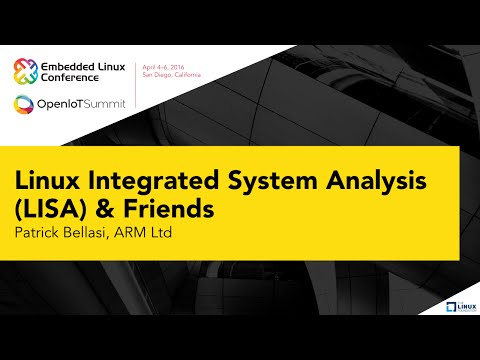

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('yXZzzUEngiU')